# Image Classification with CNNs using Keras

# Importing Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())
print('Is using GPU?', tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

TensorFlow version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? True
Is using GPU? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [2]:
tf.config.list_physical_devices()
# print('Is using GPU?', tf.config.list_physical_devices('XLA_GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Preprocessing Data

In [3]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Visualize Examples

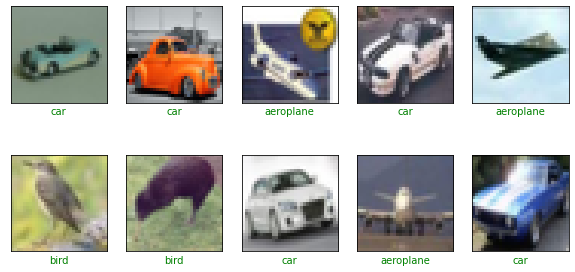

(15000, 32, 32, 3)


In [6]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)
# plt.imshow(x_train[1])
print(x_train.shape)

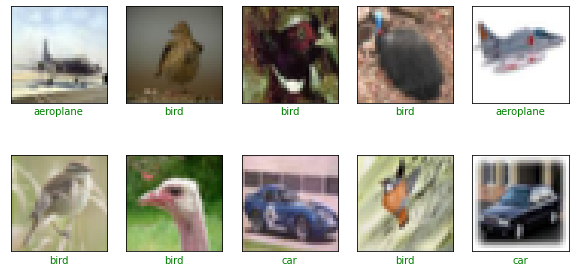

9216000


In [7]:
show_random_examples(x_test, y_test, y_test)
print(x_test.size)

# Creating Model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)       

# Training the Model

In [14]:
%%time
# with tf.device('/cpu:0'):
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, batch_size=256,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/20
59/59 [==============================] - 7s 121ms/step - loss: 0.7634 - accuracy: 0.7293 - val_loss: 1.9492 - val_accuracy: 0.3333
Epoch 2/20
59/59 [==============================] - 7s 112ms/step - loss: 0.4472 - accuracy: 0.8206 - val_loss: 2.4664 - val_accuracy: 0.3333
Epoch 3/20
59/59 [==============================] - 7s 115ms/step - loss: 0.3808 - accuracy: 0.8479 - val_loss: 2.3296 - val_accuracy: 0.3527
Epoch 4/20
59/59 [==============================] - 7s 114ms/step - loss: 0.3218 - accuracy: 0.8727 - val_loss: 2.4315 - val_accuracy: 0.4227
Epoch 5/20
59/59 [==============================] - 7s 113ms/step - loss: 0.2802 - accuracy: 0.8945 - val_loss: 2.3356 - val_accuracy: 0.4930
Epoch 6/20
59/59 [==============================] - 7s 115ms/step - loss: 0.2457 - accuracy: 0.9041 - val_loss: 2.1964 - val_accuracy: 0.5410
Epoch 7/20
59/59 [==============================] - 7s 111ms/step - loss: 0.2260 - accuracy: 0.9127 - val_loss: 1.8662 - val_accuracy: 0.5307
Epoch 

# Final Predictions

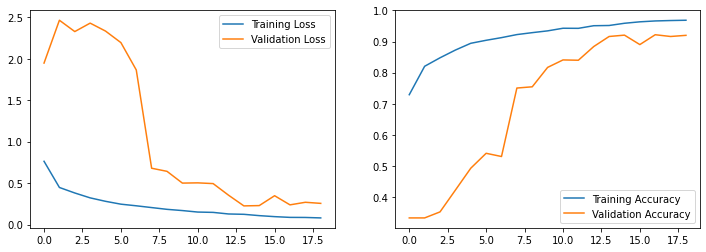

In [15]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [16]:
model = tf.keras.models.load_model('models/model_0.922.h5')
preds = model.predict(x_test/255.)

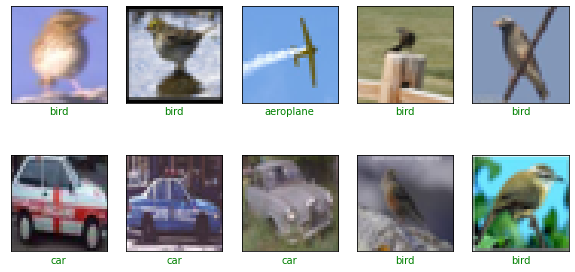

In [17]:
show_random_examples(x_test, y_test, preds)